# 1. Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
import warnings
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller

# 2. Load our data 

In [2]:
df = pd.read_csv("data.csv")

# 3. Clean and simplify our data

In [3]:
df.reset_index(inplace=True)

In [4]:
df.head()

,level_0,level_1,level_2,level_3,level_4,level_5,level_6,level_7,level_8,https://www.CryptoDataDownload.com
0,unix,date,symbol,open,high,low,close,Volume BTC,Volume USDT,tradecount
1,1642204800000,2022-01-15 00:00:00,BTC/USDT,43059.96000000,43174.00000000,42907.00000000,43006.34000000,258.78660000,11138865.93253070,10244
2,1642118400000,2022-01-14 00:00:00,BTC/USDT,42558.35000000,43448.78000000,41725.95000000,43059.96000000,32640.88292000,1392000443.35016740,946938
3,1642032000000,2022-01-13 00:00:00,BTC/USDT,43902.65000000,44500.00000000,42311.22000000,42560.11000000,34910.87762000,1515944525.49549480,1036234
4,1641945600000,2022-01-12 00:00:00,BTC/USDT,42729.29000000,44322.00000000,42450.00000000,43902.66000000,33943.29280000,1470906437.71207140,1023902


In [5]:
df.drop(['https://www.CryptoDataDownload.com', 'level_0', 'level_2', 'level_4', 'level_5', 'level_6', 'level_7', 'level_8'], 
        axis=1, inplace=True)

In [6]:
df = df.drop(0)

In [7]:
df.head()

,level_1,level_3
1,2022-01-15 00:00:00,43059.96000000
2,2022-01-14 00:00:00,42558.35000000
3,2022-01-13 00:00:00,43902.65000000
4,2022-01-12 00:00:00,42729.29000000
5,2022-01-11 00:00:00,41822.49000000


In [8]:
df = df.rename(columns={'level_1': 'Date', 'level_3': 'Price'})

In [9]:
df['Date'] = pd.to_datetime(df['Date'])

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1614 entries, 1 to 1614
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1614 non-null   datetime64[ns]
 1   Price   1614 non-null   object        
dtypes: datetime64[ns](1), object(1)
memory usage: 37.8+ KB


In [11]:
df['Price'] = df['Price'].astype(float)

In [12]:
df.head()

,Date,Price
1,2022-01-15,43059.96
2,2022-01-14,42558.35
3,2022-01-13,43902.65
4,2022-01-12,42729.29
5,2022-01-11,41822.49


In [13]:
df = df.iloc[::-1]

In [14]:
df.head()

,Date,Price
1614,2017-08-17,4469.93
1613,2017-08-18,4285.08
1612,2017-08-19,4108.37
1611,2017-08-20,4139.98
1610,2017-08-21,4086.29


# 4. Visualize our data

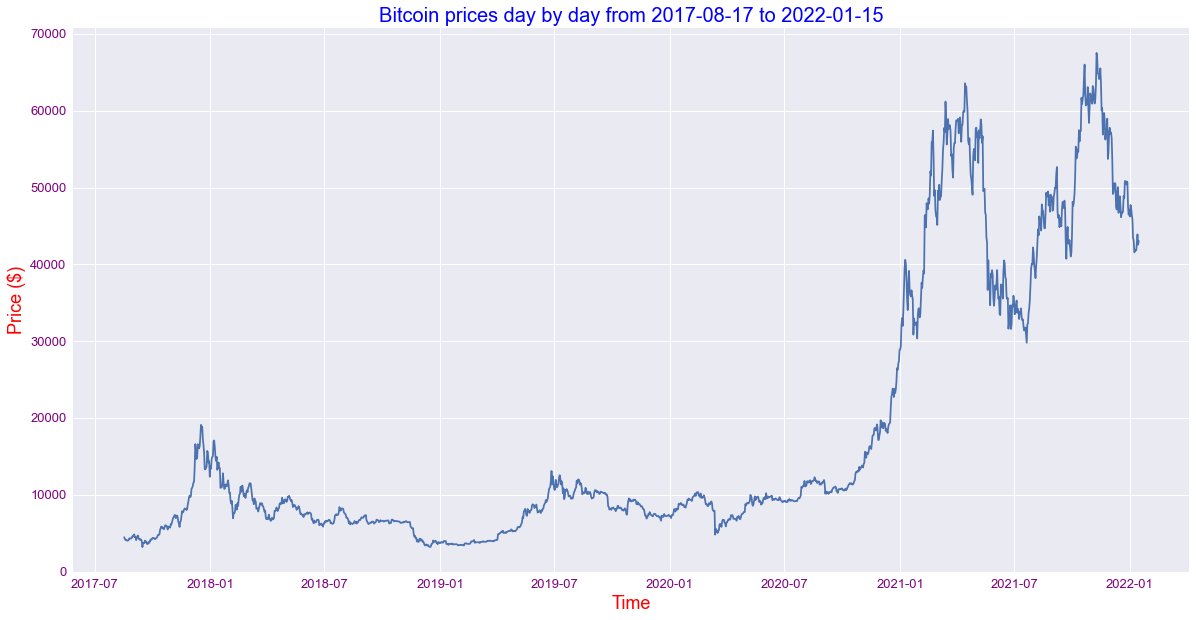

In [15]:
fig = plt.figure(figsize=(20, 10))

plt.style.use('seaborn')

plt.ticklabel_format(style='plain')
plt.xlabel("Time", fontsize=18, color='red')
plt.ylabel("Price ($)", fontsize=18, color='red')
plt.tick_params(axis='both', labelcolor='purple', labelsize=13)
plt.title("Bitcoin prices day by day from 2017-08-17 to 2022-01-15", fontsize=20, color='blue')

plt.plot(df['Date'], df['Price'])

# 5. Create a model

In [16]:
# ADF Test
result = adfuller(df['Price'], autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')    

ADF Statistic: -0.8857323280761349
n_lags: 0.7926346484657106
p-value: 0.7926346484657106
Critial Values:
   1%, -3.434461656404719
Critial Values:
   5%, -2.863356053770622
Critial Values:
   10%, -2.567736831977157


## The p-value is obtained is greater than significance level of 0.05 and the ADF statistic is higher than any of the critical values. That means that our data is non-stationary. We're gonna use ARIMA model

In [17]:
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.80)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit()
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	rmse = sqrt(mean_squared_error(test, predictions))
	return rmse

In [18]:
def evaluate_models(dataset, p_values, d_values, q_values):
	best_score, best_cfg = 1000000000, None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					rmse = evaluate_arima_model(dataset, order)
					if rmse < best_score:
						best_score, best_cfg = rmse, order
					print('ARIMA%s RMSE=%.3f' % (order,rmse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [ ]:
p_values = range(0, 3)
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(df['Price'].tolist(), p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=35797.428
ARIMA(0, 0, 1) RMSE=18688.524
ARIMA(0, 1, 0) RMSE=1843.634
ARIMA(0, 1, 1) RMSE=1844.061
ARIMA(0, 1, 2) RMSE=1847.899
ARIMA(0, 2, 0) RMSE=2700.709
ARIMA(0, 2, 1) RMSE=1858.358
ARIMA(0, 2, 2) RMSE=1856.471
ARIMA(1, 0, 0) RMSE=1842.986
ARIMA(1, 1, 0) RMSE=1844.359
ARIMA(1, 2, 0) RMSE=2295.853
ARIMA(1, 2, 1) RMSE=1856.691


## ARIMA(1, 0, 0) looks good enough so we'll stop here

In [19]:
warnings.filterwarnings("ignore")
X = df['Price'].tolist()
size = int(len(X) * 0.80)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

for t in range(len(test)):
    model = ARIMA(history, order=(1, 0, 0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print(f"predicted: {yhat}, expected: {obs}")

rmse = sqrt(mean_squared_error(test, predictions))
print(f"Test RMSE: {rmse}")

predicted: [47059.66308589], expected: 46276.88
predicted: [46262.27464353], expected: 46103.67
predicted: [46103.66995529], expected: 45134.11
predicted: [45118.68444549], expected: 49595.76
predicted: [49582.3651779], expected: 48436.61
predicted: [48422.51791995], expected: 50349.37
predicted: [50336.21323574], expected: 48374.09
predicted: [48359.67963118], expected: 48746.81
predicted: [48732.62899685], expected: 48882.2
predicted: [48868.107586], expected: 50959.11
predicted: [50946.00538053], expected: 52375.18
predicted: [52362.69741448], expected: 54874.67
predicted: [54863.06054928], expected: 55851.59
predicted: [55840.32746087], expected: 57773.15
predicted: [57762.46017929], expected: 57221.72
predicted: [57210.84250978], expected: 61188.38
predicted: [61188.37972868], expected: 58976.08
predicted: [58965.26467488], expected: 55605.2
predicted: [55592.85732228], expected: 56900.74
predicted: [56888.86500255], expected: 58912.97
predicted: [58912.96983549], expected: 57641.

predicted: [49287.88466863], expected: 48821.88
predicted: [48786.9404338], expected: 49239.22
predicted: [49204.67905847], expected: 49488.85
predicted: [49454.58418869], expected: 47674.01
predicted: [47638.26198345], expected: 48973.32
predicted: [48938.55678209], expected: 46843.86
predicted: [46807.43882425], expected: 49069.9
predicted: [49034.92819284], expected: 48895.35
predicted: [48860.31024743], expected: 48767.84
predicted: [48732.77242966], expected: 46982.91
predicted: [46946.53700982], expected: 47100.89
predicted: [47064.66026494], expected: 48810.51
predicted: [48775.41069529], expected: 49246.63
predicted: [49211.91957141], expected: 49998.0
predicted: [49963.91261699], expected: 49917.54
predicted: [49883.45709985], expected: 51756.88
predicted: [51724.2112518], expected: 52666.2
predicted: [52634.32689349], expected: 46868.57
predicted: [46831.0464694], expected: 46048.31
predicted: [46010.40172803], expected: 46395.14
predicted: [46357.47839208], expected: 44842.2

## Plot our predictions

In [24]:
len(predictions)

323

In [32]:
predicted = df.iloc[1291:1614]

In [33]:
predicted

,Date,Price
323,2021-02-27,46276.88
322,2021-02-28,46103.67
321,2021-03-01,45134.11
320,2021-03-02,49595.76
319,2021-03-03,48436.61
...,...,...
5,2022-01-11,41822.49
4,2022-01-12,42729.29
3,2022-01-13,43902.65
2,2022-01-14,42558.35


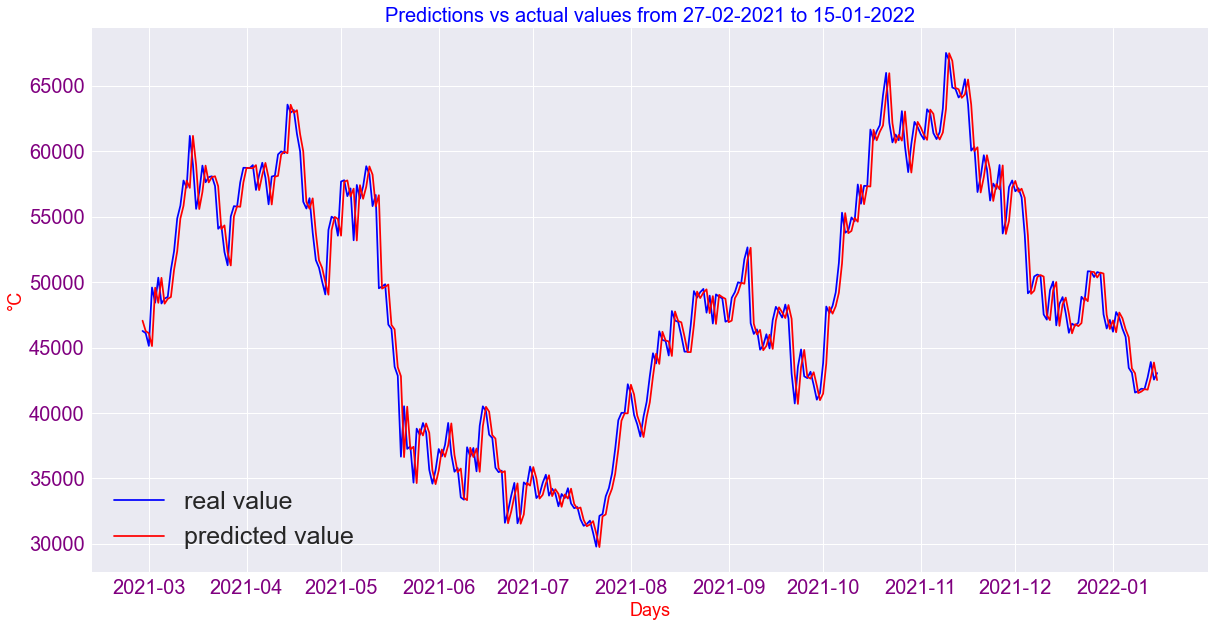

In [35]:
Days = predicted['Date']

fig = plt.figure(figsize=(20, 10))

plt.style.use('seaborn')

plt.ticklabel_format(style='plain')
plt.xlabel("Days", fontsize=18, color='red')
plt.ylabel("°C", fontsize=18, color='red')
plt.tick_params(axis='both', labelcolor='purple', labelsize=20)
plt.title("Predictions vs actual values from 27-02-2021 to 15-01-2022", fontsize=20, color='blue')
plt.plot(Days, test, color='blue', label='real value')
plt.plot(Days, predictions, color='red', label='predicted value')
plt.legend(prop={'size': 25})

## Predictions of next, 31 unknown days - from 16-01-2022 to 16-02-2022

In [47]:
warnings.filterwarnings("ignore")
X = df['Price'].tolist()
size = int(len(X))
train = X[0:size]
history = [x for x in train]
predictions = list()

for t in range(31):
    model = ARIMA(history, order=(1, 0, 0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    history.append(yhat)
    print(f"predicted: {yhat}")


predicted: [43022.73327431]
predicted: [42985.58223829]
predicted: [42948.50891332]
predicted: [42911.51653371]
predicted: [42874.59784839]
predicted: [42837.77076095]
predicted: [42801.01045829]
predicted: [42764.3261303]
predicted: [42727.71806816]
predicted: [42691.18652502]
predicted: [42654.73541095]
predicted: [42618.35528059]
predicted: [42582.05756896]
predicted: [42545.83091603]
predicted: [42509.68350322]
predicted: [42473.61174208]
predicted: [42437.62089938]
predicted: [42401.70755795]
predicted: [42365.86353903]
predicted: [42330.09685241]
predicted: [42294.40670239]
predicted: [42258.78706424]
predicted: [42223.24672322]
predicted: [42187.78027575]
predicted: [42152.38869647]
predicted: [42117.07244289]
predicted: [42081.83585807]
predicted: [42046.66869808]
predicted: [42011.57586128]
predicted: [41976.55615887]
predicted: [41941.61197774]
